In [3]:
import polars as pl
import numpy as np
import numba as nb
from numpy.typing import NDArray
import pickle
import genvarloader as gvl
from pathlib import Path
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [4]:
data_dir = Path('/iblm/netapp/data4/shared_dir/hyena_dna_collab/downstream_tasks/iPSCORE_cvpc')

### TMM Estimator

In [3]:
class TMM:
    """Trimmed Mean of M-values.

    Parameters
    ----------
    Acutoff : float, default -1e10
        Cutoff for expression values.
    logratioTrim : float, default 0.3
        Trim fraction for log ratios.
    sumTrim : float, default 0.05
        Trim fraction for absolute expression values.
    doWeighting : bool, default True
        Whether to weight the scaling factors.
    p : float, default 0.75
        Quantile to use for reference sample selection.
    """

    def __init__(
        self,
        expression_cutoff=-1e10,
        log_ratio_trim=0.3,
        expression_trim=0.05,
        apply_weighting=True,
        quantile=0.75,
    ):
        self.expression_cutoff = expression_cutoff
        self.log_ratio_trim = log_ratio_trim
        self.expression_trim = expression_trim
        self.apply_weighting = apply_weighting
        self.quantile = quantile

    @property
    def _is_fitted(self):
        return any(v.endswith("_") for v in vars(self))

    def fit(self, counts: NDArray):
        """
        Fit the TMM normalization model to the given counts.

        Parameters
        ----------
        counts : NDArray
            The raw count data to be normalized. Floating point data is ok.

        Returns
        -------
        self : TMM
            Returns self.
        """
        # choose reference sample
        # (s)
        normed_quantile = np.quantile(counts, self.quantile, axis=1) / counts.sum(1)
        if np.median(normed_quantile) < 1e-20:
            ref_idx = np.sqrt(counts).sum(1).argmax()
        else:
            ref_idx = np.abs(normed_quantile - normed_quantile.mean()).argmin()

        # (1 g)
        self.ref_counts_ = counts[[ref_idx]]
        self.ref_library_size_ = self.ref_counts_.sum(keepdims=True)

        return self

    def transform(self, counts: NDArray):
        """
        Apply the TMM normalization to the given counts.

        Parameters
        ----------
        counts : NDArray
            The raw count data to be normalized. Floating point data is ok.

        Returns
        -------
        normalized_counts : NDArray
            The normalized count data.
        """
        if not self._is_fitted:
            raise ValueError("Must fit before transforming.")

        scaling_factors, library_sizes = self._scaling_factors(counts)

        return counts / (library_sizes * scaling_factors)[:, None] * 1e6

    def _scaling_factors(self, counts: NDArray):
        """
        Compute the scaling factors for TMM normalization.

        Parameters
        ----------
        counts : NDArray
            The raw count data. Floating point data is ok.

        Returns
        -------
        scaling_factors : NDArray
            The computed scaling factors.
        library_sizes : NDArray
            The library sizes.
        """
        if not self._is_fitted:
            raise ValueError("Must fit before computing scaling factors.")

        n_samples = counts.shape[0]
        library_sizes = counts.sum(1, keepdims=True)
        with np.errstate(divide="ignore", invalid="ignore"):
            log_ratio: NDArray[np.float64] = np.log2(
                (counts / library_sizes) / (self.ref_counts_ / self.ref_library_size_)
            )
            abs_expression: NDArray[np.float64] = (
                np.log2(counts / library_sizes)
                + np.log2(self.ref_counts_ / self.ref_library_size_)
            ) / 2
            asymp_variance: NDArray[np.float64] = (
                library_sizes - counts
            ) / library_sizes / counts + (
                self.ref_library_size_ - self.ref_counts_
            ) / self.ref_library_size_ / self.ref_counts_

        finite = (
            np.isfinite(log_ratio)
            & np.isfinite(abs_expression)
            & np.isfinite(abs_expression > self.expression_cutoff)
        )

        scaling_factors = np.empty(n_samples, np.float64)
        within_tol: NDArray[np.bool_] = np.nanmax(np.abs(log_ratio), 1) < 1e-6
        scaling_factors[within_tol] = 1

        subset = finite & ~within_tol[:, None]
        n_subset: int = (~within_tol).sum()

        offsets = np.empty(n_subset + 1, np.uint32)
        offsets[0] = 0
        finite[~within_tol, :].sum(1).cumsum(out=offsets[1:])

        log_ratio = log_ratio[subset]
        abs_expression = abs_expression[subset]
        asymp_variance = asymp_variance[subset]

        scaling_factors[~within_tol] = _tmm_helper(
            log_ratio,
            abs_expression,
            asymp_variance,
            offsets,
            self.log_ratio_trim,
            self.expression_trim,
            self.apply_weighting,
        )

        return scaling_factors, library_sizes.squeeze()


@nb.njit(parallel=True, nogil=True, cache=True)
def _tmm_helper(
    log_ratio: NDArray[np.float64],
    abs_expr: NDArray[np.float64],
    var: NDArray[np.float64],
    offsets: NDArray[np.uint32],
    logratioTrim: float,
    sumTrim: float,
    doWeighting: bool,
):
    n_samples = len(offsets) - 1
    scaling_factors = np.empty(n_samples, np.float64)
    for i in nb.prange(n_samples):
        log_r = log_ratio[offsets[i] : offsets[i + 1]]
        abs_e = abs_expr[offsets[i] : offsets[i + 1]]
        v = var[offsets[i] : offsets[i + 1]]
        n = len(log_r)
        lower_log_r = np.floor(n * logratioTrim) + 1
        upper_log_r = n + 1 - lower_log_r
        lower_abs_e = np.floor(n * sumTrim) + 1
        upper_abs_e = n + 1 - lower_abs_e

        logr_ranks = log_r.argsort().argsort()
        absE_ranks = abs_e.argsort().argsort()

        in_range: NDArray[np.bool_] = (
            (logr_ranks >= lower_log_r)
            & (logr_ranks < upper_log_r)
            & (absE_ranks >= lower_abs_e)
            & (absE_ranks < upper_abs_e)
        )

        if doWeighting:
            factor = np.nansum(log_r[in_range] / v[in_range]) / np.nansum(
                1 / v[in_range]
            )
        else:
            factor = np.nanmean(log_r[in_range])

        if np.isnan(factor):
            factor = 0

        scaling_factors[i] = 2**factor
    return scaling_factors

### Squashed scaling

In [8]:
def squashed_scaled(x: NDArray[np.floating]):
    x = x**(3/4)
    x[x > 384] = 384 + np.sqrt(x[x > 384] - 384)
    return x

### Test

In [4]:
cnts = pl.read_csv(data_dir / 'counts.csv').sort('sample')
cnts.head()

sample,ENSG00000087076,ENSG00000117523,ENSG00000087111,ENSG00000145029,ENSG00000007202,ENSG00000049239,ENSG00000104980,ENSG00000043093,ENSG00000134744,ENSG00000163389,ENSG00000196152,ENSG00000181072,ENSG00000162928,ENSG00000085382,ENSG00000107362,ENSG00000101138,ENSG00000070614,ENSG00000197037,ENSG00000107020,ENSG00000138111,ENSG00000111846,ENSG00000197506,ENSG00000157510,ENSG00000198496,ENSG00000112964,ENSG00000163516,ENSG00000100916,ENSG00000131165,ENSG00000100836,ENSG00000167280,ENSG00000008294,ENSG00000254860,ENSG00000160551,ENSG00000141258,ENSG00000101605,ENSG00000120438,…,ENSG00000145020,ENSG00000178977,ENSG00000182175,ENSG00000231721,ENSG00000262664,ENSG00000129197,ENSG00000001629,ENSG00000243927,ENSG00000186814,ENSG00000197162,ENSG00000114850,ENSG00000234390,ENSG00000183914,ENSG00000100056,ENSG00000160439,ENSG00000149357,ENSG00000132623,ENSG00000126698,ENSG00000241973,ENSG00000136937,ENSG00000158006,ENSG00000140691,ENSG00000177406,ENSG00000163946,ENSG00000141627,ENSG00000214367,ENSG00000160710,ENSG00000123636,ENSG00000154065,ENSG00000114302,ENSG00000120306,ENSG00000164342,ENSG00000071127,ENSG00000143178,ENSG00000105429,ENSG00000291158,ENSG00000128581
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""001a6b85-bf54-…",94.001,3554.0,2512.001,241.14,2437.405,1570.0,988.999,1254.0,1207.001,352.0,133.0,1654.0,755.0,381.0,459.0,910.999,4216.0,320.0,279.0,17.0,1506.999,312.0,1668.001,46.0,342.0,990.0,567.0,1488.999,1278.573,375.0,1492.999,80.0,2994.0,1329.002,31512.0,4481.0,…,977.264,11.0,34.0,18.0,592.573,655.0,683.0,1713.317,364.001,109.0,7329.001,12.0,15.0,386.0,308.994,1454.0,205.0,1238.34,2193.651,1885.0,258.0,273.0,27.0,1304.001,1463.001,211.605,2655.543,762.0,43.0,2533.0,552.0,21.0,6819.001,5.0,5182.0,69.728,697.998
"""01fe3fd3-5392-…",129.0,7160.0,2508.0,259.97,3966.748,1865.0,1102.0,1088.0,1436.001,397.999,270.0,737.0,1044.001,253.0,873.0,660.0,13718.001,514.0,143.0,46.0,1269.0,17.0,612.0,81.999,489.0,607.001,389.0,2516.0,1834.923,332.001,2580.002,45.001,4213.0,1089.999,7947.0,6164.999,…,284.929,19.0,188.0,46.001,659.382,762.0,1572.0,1010.999,319.999,153.0,9407.001,20.0,66.0,430.0,184.267,1850.0,156.0,1645.962,1746.829,1753.0,655.0,358.0,54.0,1223.0,1157.001,337.152,5542.934,1819.0,108.0,2504.001,703.0,23.0,20370.001,28.0,3777.0,223.537,569.001
"""0433562a-e33e-…",89.001,3177.0,2805.999,171.044,2470.069,1492.0,1461.0,914.0,1300.001,361.0,211.0,1392.999,775.0,308.0,516.0,1030.0,3651.0,353.0,271.0,26.0,1391.0,318.0,1653.0,59.0,155.0,1102.0,528.0,2139.001,1469.674,273.999,1549.001,63.0,2192.999,1412.0,38059.001,4979.001,…,1641.346,22.0,36.0,8.0,728.713,818.999,528.0,2002.0,410.0,133.0,6944.0,6.0,3.0,461.001,381.19,1683.999,216.0,1802.727,2438.362,1950.0,271.999,358.0,85.0,1112.001,1714.0,220.597,2641.524,757.001,17.0,2412.002,493.0,43.0,8412.999,5.0,4992.0,125.04,837.002
"""08e4cd2c-dfd0-…",187.001,5612.0,3743.0,505.764,3251.564,2426.0,1303.0,1395.0,1785.998,452.0,209.0,2079.0,969.0,769.999,620.0,1011.999,4540.001,501.0,274.0,25.0,1516.0,768.0,2466.001,118.0,365.0,2029.0,506.0,2314.002,2637.503,1063.0,2595.0,115.001,4543.001,2475.001,31915.0,4389.0,…,1560.952,33.0,54.0,30.0,628.476,938.001,1117.0,2172.748,848.425,275.0,7701.0,12.0,37.0,514.0,297.671,1619.0,251.0,1511.873,2659.553,1627.0,415.0,490.001,143.0,1987.999,1814.001,335.517,4071.816,1114.155,28.0,3390.001,612.0,58.0,8640.999,27.0,6009.001,155.732,633.0
"""0a1bcb9c-aa08-…",360.0,3619.999,2509.0,224.074,3329.581,2638.0,646.001,778.999,1192.0,395.001,142.0,2894.0,606.0,275.0,614.0,812.0,4702.0,420.999,200.0,40.0,514.001,115.0,213.0,39.0,592.0,410.0,322.0,1963.997,1992.657,339.0,1870.999,80.0,2808.0,1211.999,5731.0,5678.001,…,403.419,16.0,195.0,7.0,620.72,792.0,931.0,1244.922,326.0,162.0,5573.001,15.0,4.0,422.0,49.782,19

In [5]:
ens = pl.read_csv("ens.tsv.gz", separator="\t")
genes = cnts.columns[1:]
train_genes = ens.filter(
    pl.col("Gene stable ID").is_in(genes)
    & ~pl.col("Chromosome/scaffold name").is_in(["6", "7", "X", "Y", "MT"])
)["Gene stable ID"].unique()
train_cnts = cnts[:80].select(*train_genes).to_numpy()

In [62]:
s, n = TMM().fit(train_cnts)._scaling_factors(train_cnts)
1e8 / (s * n)

array([6.30539726, 5.25549992, 5.97096546, 4.65998973, 6.10454329,
       6.12274205, 4.39700002, 5.81681554, 6.34712565, 5.64379906,
       6.4372406 , 5.58861194, 5.36117655, 4.82638821, 4.64923501,
       5.11458056, 6.26948779, 4.72540926, 5.06243459, 5.64438952,
       4.12680273, 5.12956892, 5.92152911, 6.44938174, 6.68813356,
       4.86241478, 4.93759237, 4.92090457, 5.96951417, 5.4298268 ,
       5.35462981, 4.22201709, 5.32898163, 5.82644924, 5.33260154,
       5.30797492, 4.48045831, 6.05813599, 4.85485743, 5.62773425,
       5.48194047, 4.81688535, 5.81696654, 5.62122365, 5.70106191,
       6.04238843, 6.00696532, 4.67734721, 5.69874938, 4.65444539,
       4.56437121, 5.56447254, 5.80355261, 5.03531836, 6.1972506 ,
       6.19684322, 5.57240341, 4.61573018, 6.03879371, 5.06310946,
       4.4735648 , 4.48725562, 6.39232936, 4.16219976, 4.71700799,
       4.56995812, 5.54821292, 4.81046868, 5.11956454, 5.34070883,
       5.53862826, 4.18002548, 5.76686115, 4.71490915, 6.29007

<Axes: ylabel='Count'>

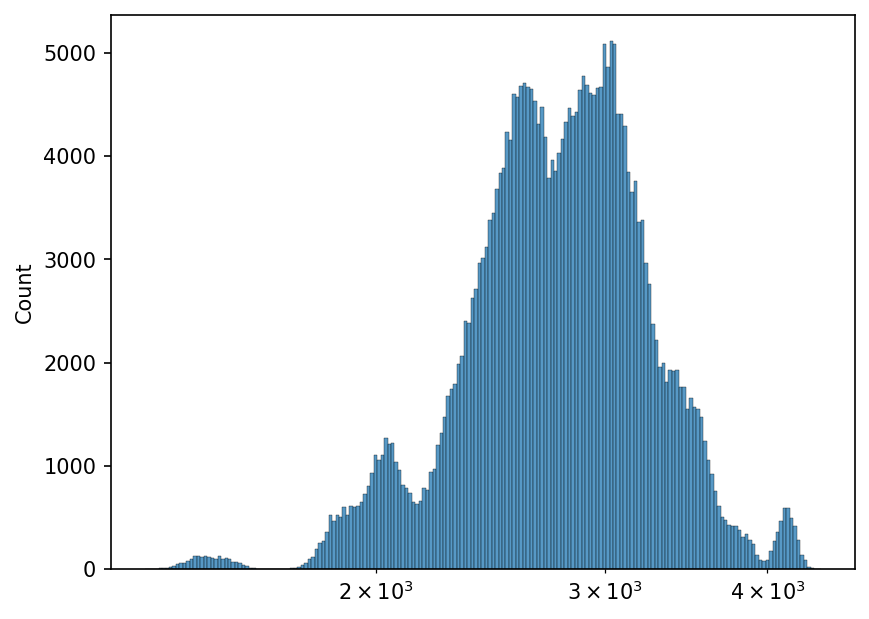

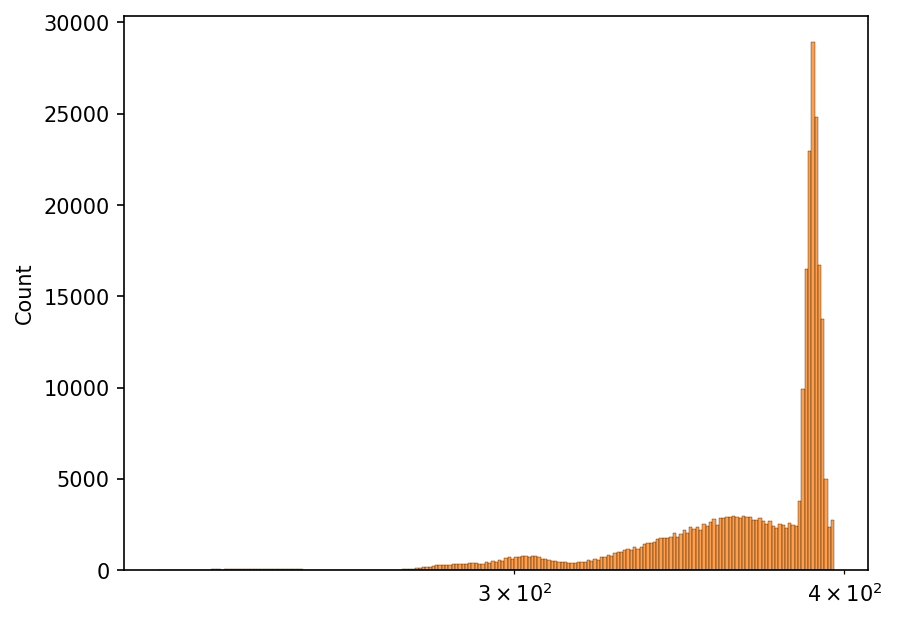

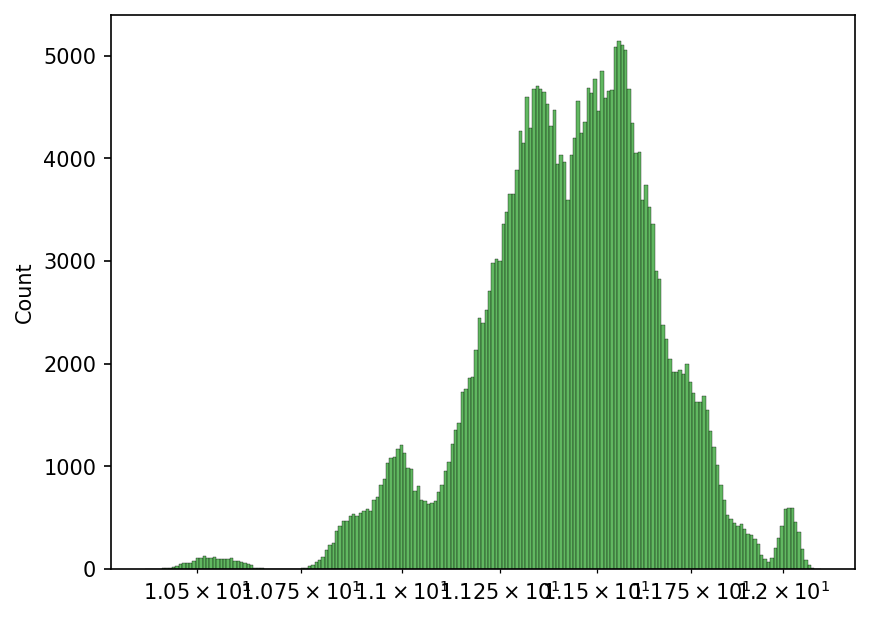

In [17]:
np.random.seed(10)
mean = 2791
std = 500
shape = mean**2 / std**2
scale = std**2 / mean
x = np.random.poisson(np.random.gamma(shape, scale, 300), (int(1e3), 300)).ravel().astype(np.float32)
fig, ax = plt.subplots(dpi=150)
sns.histplot(x, color='C0', log_scale=True, label='Original')

squashed = squashed_scaled(x)
fig, ax = plt.subplots(dpi=150)
sns.histplot(squashed, color='C1', log_scale=True, label='Squashed')

logged = np.log1p(x) / np.log(2)
fig, ax = plt.subplots(dpi=150)
sns.histplot(logged, log_scale=True, color='C2', label='Logged')

# plt.legend(loc='best');

In [7]:
ds = gvl.Dataset.open(
    data_dir / "gvl" / "cvpc_f25k_l2p17_top5k.gvl",
    data_dir / 'hg38.fa'
)

2024-03-29 17:33:08.358 | INFO     | genvarloader.dataset:open:133 - Loading reference genome into memory. This typically has a modest memory footprint (a few GB) and greatly improves performance.
2024-03-29 17:33:55.905 | INFO     | genvarloader.dataset:open:186 - 
GVL store cvpc_f25k_l2p17_top5k.gvl
Original region length: 131,072
Max jitter: 1,024
# of samples: 132
# of regions: 2,786
Has genotypes: True
Has intervals: True
Is subset: False


In [170]:
# very strange to see values of 0 in intervals
zero_intervals = (ds.intervals.values == 0).nonzero()[0]

In [172]:
lengths = np.diff(ds.intervals.intervals[zero_intervals], axis=-1)

In [208]:
len(ds)

367752

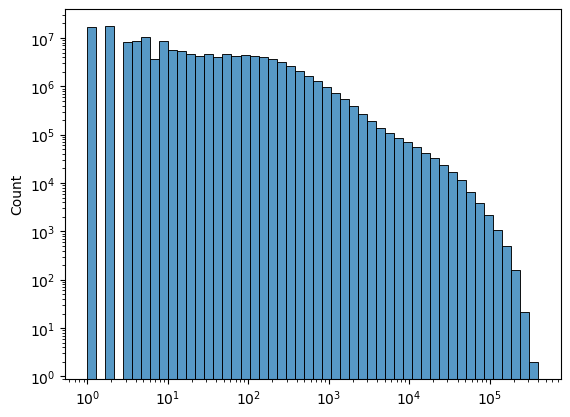

In [216]:
ax = sns.histplot(ds.intervals.values, log_scale=True, bins=50)
ax.set(yscale='log');

In [211]:
s, e = ds.intervals.offsets[0], ds.intervals.offsets[1]
(
    # ds.intervals.intervals[s:e],
    ds.intervals.values[s:e]
)

memmap([0.0000e+00, 3.0000e+00, 0.0000e+00, 1.1000e+01, 0.0000e+00,
        3.9000e+01, 0.0000e+00, 1.0000e+00, 3.0000e+00, 0.0000e+00,
        3.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        3.0000e+00, 2.0000e+00, 0.0000e+00, 3.0000e+00, 0.0000e+00,
        2.0000e+00, 4.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00,
        3.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 2.1200e+02,
        3.1400e+02, 4.6100e+02, 9.3900e+02, 1.9010e+03, 2.6800e+03,
        2.4650e+03, 1.8070e+03, 5.7400e+02, 2.4000e+01, 3.4000e+01,
        2.2000e+02, 3.6435e+04, 4.9422e+04, 5.3783e+04, 5.3073e+04,
        2.9623e+04, 1.8721e+04, 1.4495e+04, 7.3480e+03, 1.3520e+03,
        1.7400e+02, 3.8500e+02, 1.0520e+03, 1.8120e+03, 3.2960e+03,
        3.5790e+03, 2.7460e+03, 2.0210e+03, 8.1000e+01, 5.1000e+01,
        4.0000e+01, 1.5000e+01, 1.4000e+01, 3.9354e+04, 4.6351e+04,
        4.6921e+04, 2.7625e+04, 6.8130e+03, 2.71

[None]

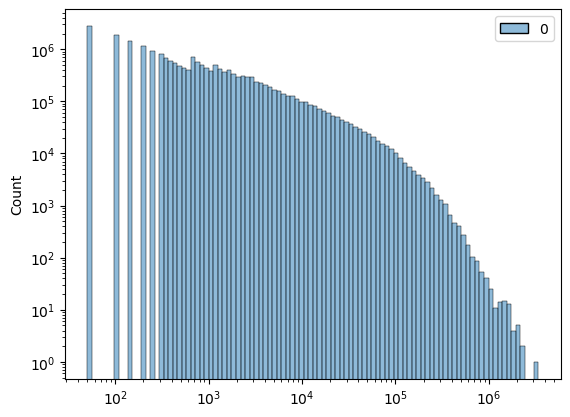

In [201]:
ax = sns.histplot(lengths, log_scale=True, bins=100)
ax.set(yscale='log')

In [163]:
20646764 / 163485159

0.12629136568904092

In [158]:
# how many instances have no intervals?
(np.diff(ds.intervals.offsets) == 0).sum()

0

In [166]:
ds = ds.with_settings(sequence_mode="reference")

In [12]:
# (s, r)
maxes = np.empty(ds.shape, np.float32)
for i in tqdm(range(ds.n_samples)):
    samples = np.full(ds.n_regions, i)
    regions = np.arange(ds.n_regions)
    # (r, l)
    track = ds.isel(samples, regions)
    maxes[i, :] = np.max(track, -1)

  0%|          | 0/132 [00:00<?, ?it/s]

In [14]:
maxes.max(1)

array([6.78330e+04, 1.50000e+02, 1.05500e+03, 2.45500e+04, 1.14300e+03,
       2.86000e+02, 7.56000e+02, 1.09260e+04, 6.47000e+02, 1.05100e+03,
       6.21000e+02, 5.56200e+03, 3.92500e+03, 9.88700e+03, 2.48000e+02,
       7.11000e+02, 8.81100e+03, 3.10200e+03, 9.22000e+02, 1.09370e+04,
       1.17590e+04, 1.43000e+03, 3.11700e+03, 1.23100e+03, 3.79000e+02,
       3.46000e+03, 1.35460e+04, 3.35200e+03, 1.00000e+00, 8.98400e+03,
       2.39940e+04, 1.85600e+03, 1.38470e+04, 6.59000e+03, 4.03400e+03,
       1.27760e+04, 1.91000e+02, 2.82900e+03, 3.70000e+01, 3.29500e+03,
       3.47800e+03, 3.24000e+03, 2.93600e+03, 8.37900e+03, 1.82400e+03,
       7.06000e+02, 5.36000e+02, 6.23000e+02, 2.20430e+04, 8.19300e+03,
       4.84600e+03, 1.04970e+04, 1.04500e+03, 3.28000e+02, 9.34000e+02,
       6.82950e+04, 3.26700e+03, 8.66000e+02, 1.74100e+03, 5.72000e+02,
       3.76000e+02, 1.43000e+02, 5.72100e+03, 1.20200e+03, 3.40700e+03,
       4.71900e+03, 1.68900e+03, 2.96700e+03, 8.13500e+03, 3.580

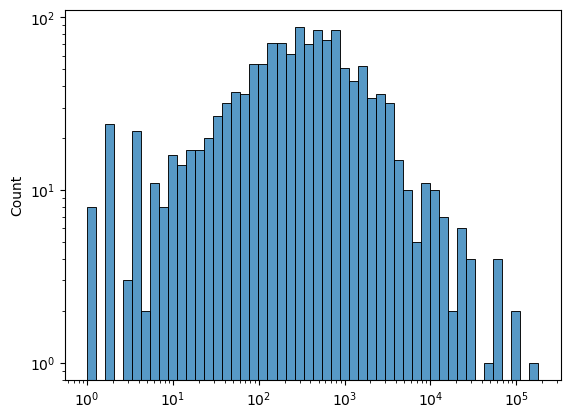

In [13]:
ax = sns.histplot(maxes.ravel(), log_scale=True, bins=50)
ax.set(yscale='log');